In [67]:
import os.path
import math
import re
import tensorflow as tf
import numpy as np
import facenet
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, Birch
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import time
%matplotlib inline

In [184]:
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model, sess):
    model_exp = os.path.expanduser(model)
    print('Model directory: %s' % model_exp)
    meta_file, ckpt_file = get_model_filenames(model_exp)

    print('Metagraph file: %s' % meta_file)
    print('Checkpoint file: %s' % ckpt_file)

    saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file))
    saver.restore(sess, os.path.join(model_exp, ckpt_file))
    
def forward(paths, batch_size):
    nrof_images = len(paths)
    nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))

    for i in range(nrof_batches):    
        start_index = i*batch_size
        end_index = min((i+1)*batch_size, nrof_images)
        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
        emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)    
        print("batch number:", i)
    print("Complete")
    
    return emb_array

def printDistance(emb_array, label_list, end=10):
    threshold = 1.0
    lng = len(emb_array[:end])
    print('Distance matrix')
    print('    ', end='')
    for i in range(lng):
        print('    %3d     ' % i, end='')
    print('')
    for i in range(lng):
        print('%1d  ' % i, end='')
        for j in range(lng):
            dist = np.linalg.norm(emb_array[i,:] - emb_array[j,:])
            print('  %1.4f' % dist, end='')
            if (label_list[i] == label_list[j]) and (dist <= threshold):
                print("(TP)", end='')
            elif (label_list[i] != label_list[j]) and (dist > threshold):
                print("(TN)", end='')
            elif (label_list[i] == label_list[j]) and (dist > threshold):
                print("\033[93m(FN)\033[0m", end='')
            elif (label_list[i] != label_list[j]) and (dist <= threshold):
                print("\033[93m(FP)\033[0m", end='')
        print('')
        
def printData(labels, paths, number):
    for i in range(number):
        if i > 0 and labels[i] != labels[i-1]:
            print('')
        print('{0:3d} {1:3d}   {2:s}'.format(i, labels[i], paths[i].split("\\")[1]))
        # print('{0:3d}   {1:s}'.format(labels[i], paths[i].split("\\")[1]))
        
def PCAtransform(emb_array, n_components = 10):
    pca = PCA(n_components, whiten=True)
    pca.fit(emb_array)
    return pca.transform(emb_array), pca

def splitTrainTest(data_set, percent_train):
    paths, labels_list = facenet.get_image_paths_and_labels(data_set)
    
    lng = len(paths)
    lng_train = int(lng * percent_train / 100);
    lng_test = lng - lng_train
    
    train_paths = paths[0:lng_train]
    test_paths = paths[lng_train:]
    
    train_labels = labels_list[0:lng_train]
    test_labels = labels_list[lng_train:]
    
    return train_paths, train_labels, test_paths, test_labels

def preprocessing(X, num_components = 50):
    num_features = X.shape[1]
    
    X = X - np.mean(X, axis=0) # centering
    X = X / X.std(axis=0) # standardization

    # PCA
    cov = np.cov(X.T)
    eig_vals, eig_vecs = np.linalg.eig(cov)

    for ev in eig_vecs:
        np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()

    pca_matrix = eig_pairs[0][1].reshape(num_features, 1)

    for i in range(1, num_components):
        pca_matrix = np.hstack((pca_matrix,
                                eig_pairs[i][1].reshape(num_features, 1)))

    X = X.dot(pca_matrix)

    # Whitening
    X = X / np.sqrt(eig_vals[:num_components])
    
    return X
    

def trainFisher(emb_array, y):
    emb_del = np.empty_like(emb_array)
    np.copyto(emb_del, emb_array)
    
    emb_array = np.vstack((emb_array, y))
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w

def trainFisherWithNum(emb_array, sample_number):    
    y = emb_array[sample_number]
    emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w   

def Fisher(w, c, sample):
    return np.dot(w / np.linalg.norm(w), sample) - c

In [3]:
sess = tf.Session()
data_set = facenet.get_dataset("../../datasets/lfw/lfw_mtcnnpy_160/")
train_paths, train_labels, test_paths, test_labels = splitTrainTest(data_set, 100)
load_model("20170511-185253", sess)

images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

image_size = 160
embedding_size = embeddings.get_shape()[1]

Model directory: 20170511-185253
Metagraph file: model-20170511-185253.meta
Checkpoint file: model-20170511-185253.ckpt-80000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from 20170511-185253\model-20170511-185253.ckpt-80000


In [12]:
emb_array = np.load('embeddings.npy')

In [15]:
t = emb_array

# Centering
tc = t - np.mean(t, axis=0)

# Standartization
ts = tc / tc.std(axis=0)

# PCA
X = ts

num_components = 50

cov = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(cov)

for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything is ok!')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

pca_matrix = eig_pairs[0][1].reshape(128, 1)

for i in range(1, num_components):
    pca_matrix = np.hstack((pca_matrix,
                            eig_pairs[i][1].reshape(128, 1)))

X_pca = X.dot(pca_matrix)

# Whitening
X_whit = X_pca / np.sqrt(eig_vals[:num_components])

Everything ok!


**Fisher's discriminant**

In [240]:
bush_label = 1871
idx, = np.where(train_labels == bush_label)

X_work = np.delete(X_whit, idx, axis=0)
c, w = trainFisher(X_work, X_whit[idx[0]])

lng = len(X_whit)
summ = 0
thr = 0.7
answers = []

for i in range(lng):
    l = Fisher(w, thr, X_whit[i]/np.linalg.norm(X_whit[i]))
    answers.append(l)
    
answers = np.asarray(answers)
true_labels = np.array(train_labels == bush_label, dtype=int)
prediction = np.array(answers > 0, dtype=int)

print("Precision: ", metrics.precision_score(true_labels, prediction))
print("Recall:    ", metrics.recall_score(true_labels, prediction))

Precision:  1.0
Recall:     0.152830188679


**FN and FP**

In [249]:
fn = len(prediction[idx][prediction[idx] != true_labels[idx]])
fnr = fn / len(true_labels[idx])

print("Elements:             ", len(prediction[idx]))
print("False Negatives:      ", fn)
print("False Negatives Rate: ", fnr)
print("")

idx2, = np.where(train_labels != bush_label)
fp = len(prediction[idx2][prediction[idx2] != true_labels[idx2]])
fpr = fp / len(true_labels[idx2])

print("Elements:             ", len(prediction[idx2]))
print("False Positives:      ", fp)
print("False Positives Rate: ", fpr)

Elements:              530
False Negatives:       449
False Negatives Rate:  0.8471698113207548

Elements:              12703
False Positives:       0
False Positives Rate:  0.0


**Array of FN and FP**

In [254]:
labels = np.unique(train_labels)

fps = []
fns = []

In [263]:
lng = len(X_whit)
thr = 0.7

for lb in labels:
    answers = []
    idx, = np.where(train_labels == lb)
    print(idx)

    X_work = np.delete(X_whit, idx, axis=0)
    c, w = trainFisher(X_work, X_whit[idx[0]])
    
    for i in range(lng):
        l = Fisher(w, thr, X_whit[i]/np.linalg.norm(X_whit[i]))
        answers.append(l)
    
    answers = np.asarray(answers)
    true_labels = np.array(train_labels == bush_label, dtype=int)
    prediction = np.array(answers > 0, dtype=int)
    
    fn = len(prediction[idx][prediction[idx] != true_labels[idx]])
    fnr = fn / len(true_labels[idx])
    
    idx2, = np.where(train_labels != bush_label)
    fp = len(prediction[idx2][prediction[idx2] != true_labels[idx2]])
    fpr = fp / len(true_labels[idx2])
    
    fns.append(fnr)
    fps.append(fpr)

[0]
[1]
[2]
[3]
[4]
[5 6 7 8]
[9]
[10 11]
[12]
[13]
[14]
[15]
[16]
[17 18]
[19 20 21 22]
[23]
[24]
[25]
[26 27 28 29]
[30]
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[50]
[51 52 53]
[54 55]
[56]
[57 58 59 60]
[61 62 63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73 74 75 76]
[77 78]
[79 80 81]
[82]
[83]
[84 85 86]
[87 88]
[89]
[90]
[91]
[92 93]
[94]
[95 96]
[97]
[98]
[99]
[100 101 102 103 104 105 106 107 108 109 110 111]
[112]
[113]
[114]
[115]
[116]
[117 118]
[119]
[120 121 122 123 124]
[125]
[126]
[127]
[128]
[129]
[130 131]
[132 133 134 135 136]
[137 138 139]
[140]
[141]
[142]
[143]
[144]
[145 146]
[147]
[148]
[149]
[150 151 152]
[153 154 155]
[156]
[157]
[158]
[159 160]
[161 162 163 164 165 166 167 168]
[169]
[170 171 172]
[173 174 175 176 177 178 179]
[180]
[181]
[182 183]
[184]
[185]
[186 187 188 189 190]
[191]
[192]
[193 194]
[195]
[196]
[197]
[198]
[199]
[200]
[201 202 203 204 205]
[206]
[207]
[208]
[209 210 211 212 213 214]
[215]
[216]
[217]
[218]
[219 220]


[1572]
[1573]
[1574]
[1575 1576 1577 1578]
[1579 1580]
[1581 1582]
[1583]
[1584]
[1585]
[1586]
[1587]
[1588]
[1589]
[1590]
[1591]
[1592]
[1593]
[1594 1595 1596 1597]
[1598]
[1599]
[1600]
[1601 1602 1603 1604 1605 1606]
[1607]
[1608 1609]
[1610]
[1611 1612]
[1613]
[1614]
[1615]
[1616 1617 1618 1619 1620 1621]
[1622]
[1623]
[1624 1625 1626 1627 1628 1629]
[1630 1631]
[1632]
[1633]
[1634]
[1635]
[1636]
[1637 1638 1639]
[1640 1641 1642 1643]
[1644]
[1645]
[1646]
[1647]
[1648]
[1649]
[1650 1651]
[1652 1653 1654 1655 1656]
[1657]
[1658]
[1659]
[1660 1661]
[1662]
[1663]
[1664 1665 1666]
[1667]
[1668]
[1669]
[1670]
[1671]
[1672]
[1673]
[1674 1675]
[1676]
[1677]
[1678 1679]
[1680]
[1681]
[1682]
[1683 1684 1685]
[1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700
 1701 1702 1703 1704 1705 1706]
[1707 1708]
[1709 1710 1711 1712 1713 1714 1715 1716 1717 1718 1719 1720 1721 1722 1723
 1724 1725 1726 1727]
[1728 1729 1730]
[1731]
[1732]
[1733 1734]
[1735]
[1736 1737 1738]
[17

[2948]
[2949]
[2950 2951]
[2952]
[2953]
[2954]
[2955]
[2956]
[2957]
[2958]
[2959]
[2960]
[2961 2962]
[2963 2964]
[2965]
[2966]
[2967 2968]
[2969]
[2970]
[2971 2972 2973 2974 2975 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985]
[2986]
[2987]
[2988]
[2989]
[2990]
[2991]
[2992]
[2993]
[2994]
[2995 2996]
[2997 2998 2999 3000]
[3001]
[3002]
[3003 3004]
[3005 3006 3007 3008]
[3009]
[3010]
[3011]
[3012 3013 3014]
[3015]
[3016 3017 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027 3028 3029 3030
 3031 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041 3042 3043 3044 3045
 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055 3056 3057 3058 3059 3060
 3061 3062 3063 3064 3065 3066 3067 3068 3069 3070 3071 3072 3073 3074 3075
 3076 3077 3078 3079 3080 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090
 3091 3092 3093 3094 3095 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105
 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120
 3121 3122 3123 3124 3125 3126 3127 3128 3129 31

[4478 4479]
[4480]
[4481]
[4482]
[4483]
[4484]
[4485]
[4486]
[4487]
[4488]
[4489 4490 4491 4492]
[4493]
[4494]
[4495 4496]
[4497]
[4498]
[4499]
[4500 4501]
[4502]
[4503]
[4504 4505 4506 4507 4508 4509 4510 4511 4512 4513 4514 4515 4516 4517 4518
 4519 4520 4521 4522 4523 4524 4525 4526 4527 4528 4529 4530 4531 4532 4533
 4534 4535 4536 4537 4538 4539 4540 4541 4542 4543 4544 4545 4546 4547 4548
 4549 4550 4551 4552 4553 4554 4555 4556 4557 4558 4559 4560 4561 4562 4563
 4564 4565 4566 4567 4568 4569 4570 4571 4572 4573 4574 4575 4576 4577 4578
 4579 4580 4581 4582 4583 4584 4585 4586 4587 4588 4589 4590 4591 4592 4593
 4594 4595 4596 4597 4598 4599 4600 4601 4602 4603 4604 4605 4606 4607 4608
 4609 4610 4611 4612]
[4613]
[4614]
[4615 4616 4617 4618 4619 4620 4621 4622]
[4623]
[4624 4625]
[4626]
[4627]
[4628 4629 4630]
[4631]
[4632 4633 4634]
[4635]
[4636]
[4637]
[4638]
[4639]
[4640 4641 4642 4643 4644]
[4645 4646 4647 4648]
[4649]
[4650]
[4651 4652]
[4653]
[4654]
[4655]
[4656]
[4657]
[

[5891]
[5892]
[5893]
[5894]
[5895]
[5896]
[5897]
[5898]
[5899]
[5900]
[5901]
[5902 5903 5904 5905 5906 5907 5908 5909 5910 5911]
[5912]
[5913]
[5914 5915 5916]
[5917]
[5918]
[5919 5920 5921 5922 5923 5924]
[5925 5926 5927]
[5928 5929]
[5930]
[5931]
[5932 5933 5934]
[5935 5936]
[5937 5938]
[5939 5940]
[5941]
[5942 5943 5944 5945 5946 5947 5948 5949 5950 5951]
[5952]
[5953 5954 5955]
[5956]
[5957]
[5958 5959]
[5960]
[5961]
[5962 5963 5964 5965 5966 5967 5968]
[5969]
[5970 5971]
[5972 5973]
[5974 5975]
[5976 5977 5978 5979 5980 5981 5982 5983 5984 5985 5986 5987 5988 5989 5990
 5991 5992]
[5993 5994 5995 5996 5997 5998 5999 6000 6001 6002 6003 6004 6005 6006 6007
 6008 6009 6010 6011 6012 6013 6014 6015 6016 6017 6018 6019 6020 6021 6022
 6023 6024 6025 6026 6027 6028 6029 6030 6031 6032 6033 6034 6035 6036 6037
 6038 6039 6040 6041 6042 6043 6044 6045 6046 6047]
[6048]
[6049]
[6050]
[6051]
[6052]
[6053]
[6054 6055]
[6056]
[6057 6058 6059 6060 6061 6062 6063 6064 6065 6066 6067 6068]
[606

[7314]
[7315]
[7316 7317 7318 7319 7320]
[7321 7322 7323 7324 7325 7326]
[7327]
[7328]
[7329]
[7330]
[7331]
[7332]
[7333]
[7334]
[7335 7336]
[7337]
[7338]
[7339]
[7340 7341]
[7342]
[7343]
[7344]
[7345]
[7346]
[7347]
[7348 7349]
[7350 7351 7352 7353 7354 7355 7356 7357 7358]
[7359]
[7360]
[7361]
[7362]
[7363 7364 7365 7366]
[7367]
[7368]
[7369 7370 7371 7372]
[7373]
[7374]
[7375 7376]
[7377 7378 7379 7380]
[7381 7382]
[7383]
[7384]
[7385]
[7386]
[7387]
[7388]
[7389 7390]
[7391]
[7392]
[7393 7394 7395]
[7396]
[7397]
[7398]
[7399]
[7400]
[7401]
[7402]
[7403]
[7404]
[7405 7406 7407 7408 7409 7410 7411 7412 7413 7414 7415 7416]
[7417]
[7418 7419]
[7420]
[7421 7422 7423]
[7424]
[7425]
[7426]
[7427]
[7428]
[7429]
[7430]
[7431]
[7432]
[7433]
[7434]
[7435]
[7436]
[7437 7438]
[7439]
[7440]
[7441 7442 7443]
[7444]
[7445]
[7446]
[7447]
[7448]
[7449 7450 7451]
[7452 7453 7454]
[7455]
[7456]
[7457]
[7458]
[7459 7460 7461]
[7462 7463]
[7464]
[7465]
[7466 7467 7468]
[7469 7470]
[7471]
[7472]
[7473]
[7

[8682]
[8683 8684 8685]
[8686]
[8687]
[8688]
[8689 8690 8691 8692]
[8693]
[8694]
[8695]
[8696]
[8697]
[8698]
[8699]
[8700 8701 8702]
[8703]
[8704]
[8705]
[8706]
[8707]
[8708]
[8709 8710 8711]
[8712]
[8713 8714]
[8715]
[8716]
[8717 8718]
[8719]
[8720]
[8721]
[8722]
[8723]
[8724]
[8725 8726 8727]
[8728 8729 8730]
[8731]
[8732]
[8733]
[8734 8735 8736 8737]
[8738 8739 8740]
[8741 8742 8743]
[8744]
[8745]
[8746]
[8747]
[8748]
[8749]
[8750]
[8751 8752 8753 8754]
[8755]
[8756]
[8757]
[8758 8759 8760 8761 8762 8763 8764]
[8765]
[8766]
[8767]
[8768 8769]
[8770]
[8771]
[8772]
[8773]
[8774]
[8775]
[8776]
[8777]
[8778]
[8779 8780]
[8781]
[8782]
[8783]
[8784]
[8785]
[8786]
[8787]
[8788 8789 8790]
[8791 8792 8793 8794 8795 8796 8797 8798 8799 8800 8801 8802 8803 8804 8805
 8806 8807 8808 8809 8810 8811 8812 8813 8814 8815 8816 8817 8818 8819 8820
 8821 8822 8823]
[8824 8825]
[8826]
[8827]
[8828]
[8829]
[8830]
[8831 8832]
[8833 8834]
[8835]
[8836]
[8837 8838 8839]
[8840]
[8841]
[8842]
[8843]
[8844 88

[10043 10044 10045 10046 10047 10048 10049]
[10050]
[10051]
[10052]
[10053 10054 10055 10056 10057]
[10058]
[10059]
[10060 10061 10062 10063]
[10064]
[10065]
[10066]
[10067 10068]
[10069 10070 10071]
[10072]
[10073]
[10074]
[10075]
[10076]
[10077]
[10078]
[10079]
[10080]
[10081]
[10082 10083 10084 10085 10086 10087 10088 10089 10090 10091 10092 10093
 10094 10095 10096 10097 10098 10099]
[10100]
[10101]
[10102 10103 10104]
[10105]
[10106 10107]
[10108 10109 10110 10111 10112 10113 10114 10115 10116 10117 10118 10119
 10120 10121 10122 10123 10124 10125 10126 10127 10128 10129]
[10130]
[10131]
[10132 10133 10134]
[10135 10136]
[10137]
[10138]
[10139]
[10140]
[10141 10142]
[10143]
[10144]
[10145]
[10146]
[10147]
[10148]
[10149 10150]
[10151]
[10152 10153]
[10154]
[10155]
[10156 10157]
[10158]
[10159]
[10160]
[10161]
[10162]
[10163]
[10164]
[10165]
[10166]
[10167]
[10168]
[10169]
[10170]
[10171]
[10172]
[10173]
[10174 10175 10176 10177 10178]
[10179]
[10180 10181 10182]
[10183 10184]
[101

[11221 11222 11223]
[11224 11225]
[11226]
[11227]
[11228]
[11229]
[11230]
[11231 11232 11233 11234]
[11235 11236 11237 11238]
[11239 11240]
[11241 11242 11243 11244 11245 11246 11247 11248 11249 11250 11251 11252
 11253]
[11254]
[11255 11256 11257]
[11258 11259 11260]
[11261]
[11262]
[11263 11264]
[11265]
[11266 11267 11268]
[11269]
[11270]
[11271]
[11272]
[11273 11274]
[11275]
[11276 11277]
[11278 11279 11280 11281]
[11282]
[11283]
[11284]
[11285 11286 11287 11288]
[11289]
[11290]
[11291]
[11292]
[11293]
[11294]
[11295]
[11296]
[11297]
[11298]
[11299]
[11300 11301]
[11302]
[11303]
[11304]
[11305 11306 11307 11308 11309 11310]
[11311 11312 11313 11314 11315 11316]
[11317 11318 11319]
[11320]
[11321]
[11322]
[11323]
[11324]
[11325]
[11326]
[11327]
[11328]
[11329]
[11330]
[11331]
[11332]
[11333]
[11334]
[11335 11336 11337 11338 11339]
[11340 11341]
[11342]
[11343 11344 11345 11346 11347]
[11348 11349]
[11350]
[11351 11352]
[11353 11354]
[11355]
[11356]
[11357]
[11358]
[11359 11360]
[1136

[12393]
[12394 12395]
[12396]
[12397]
[12398 12399 12400]
[12401]
[12402]
[12403]
[12404 12405 12406 12407]
[12408 12409 12410 12411 12412 12413 12414 12415 12416 12417 12418 12419
 12420 12421 12422 12423 12424 12425 12426 12427 12428 12429 12430 12431
 12432 12433 12434 12435 12436 12437 12438 12439 12440 12441 12442 12443
 12444 12445 12446 12447 12448 12449 12450 12451 12452 12453 12454 12455
 12456 12457 12458 12459 12460 12461 12462 12463 12464 12465 12466 12467
 12468 12469 12470 12471 12472 12473 12474 12475 12476 12477 12478 12479
 12480 12481 12482 12483 12484 12485 12486 12487 12488 12489 12490 12491
 12492 12493 12494 12495 12496 12497 12498 12499 12500 12501 12502 12503
 12504 12505 12506 12507 12508 12509 12510 12511 12512 12513 12514 12515
 12516 12517 12518 12519 12520 12521 12522 12523 12524 12525 12526 12527
 12528 12529 12530 12531 12532 12533 12534 12535 12536 12537 12538 12539
 12540 12541 12542 12543 12544 12545 12546 12547 12548 12549 12550 12551]
[12552]
[12553]

(array([   32.,   104.,    99.,   194.,   534.,    44.,   114.,    87.,
           21.,  4521.]),
 array([ 0.02380952,  0.12142857,  0.21904762,  0.31666667,  0.41428571,
         0.51190476,  0.60952381,  0.70714286,  0.8047619 ,  0.90238095,  1.        ]),
 <a list of 10 Patch objects>)

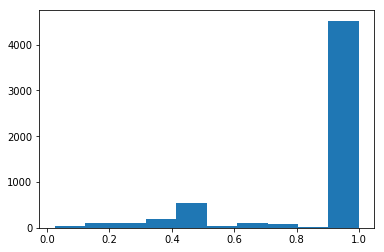

In [280]:
plt.hist(fns)